# Offering recommendations from the new clusters

This part of the project is still in progress and is currently only in early stages.

The first part of this notebook looks at building a basic content based recommendation to offer similar items based on the final clusters.

The original intention for the project had been to use LightFM's hybrid recommendation system functionality to check the validity of the new clusters. There is plenty more to be done on this part of the project.

In [1]:
import numpy
import pandas as pd
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
working_filepath = '../'
# Spotify feature data
spot = pd.read_csv(working_filepath + 'SQL_SpotifyMetrics_Export.csv', index_col=0)
# RYM ratings data
ratings = pd.read_csv(working_filepath + 'SQL_Ratings_Export.csv', index_col=0)
# Genre Ids
rym_genres = pd.read_csv(working_filepath + 'SQL_RYM_Genre_Export.csv', index_col=0)
# Album data
albums = pd.read_csv(working_filepath + 'SQL_Album_Export.csv', index_col=0)
# Album genre data
album_genres = pd.read_csv(working_filepath + 'SQL_Album_genres_Export.csv', index_col=0)


In [3]:
spot.columns = ['acousticness', 'analysisUrl', 'danceability', 'duration_ms', 'energy',
       'spotId', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'songId', 'songName', 'speechiness', 'tempo', 'timeSignature',
       'trackHref', 'type', 'uri', 'valence', 'albumId', 'artistName',
       'artistId', 'albumName']

In [4]:
ratings.columns = ['ratingId', 'score', 'ratingYear',
                   'ratingMonth', 'ratingDay', 'identifierRYM',
                   'albumId', 'profileId']

In [5]:
df = pd.merge(spot, ratings, on = 'albumId', how = 'left')

In [6]:
rym_genres.columns = ['genreId', 'genreName']

In [7]:
album_genres = pd.merge(album_genres, rym_genres, on = 'genreId', how = 'left')

We have some albums with multiple genres. We will arbitrarily remove these duplicates.

In [8]:
album_genres = album_genres.sort_values('albumId').drop_duplicates(subset = 'albumId')

Connect them all now.

In [9]:
df = pd.merge(df, album_genres, on = 'albumId', how = 'left')

In [10]:
df.dropna(inplace = True)

Lets see our most active users.

In [11]:
users = list(df['profileId'].value_counts().index)
users[0:5]

[60.0, 42.0, 85.0, 14.0, 69.0]

In [12]:
# Clean up
del spot, ratings, rym_genres, albums, album_genres

# Recommendation-based Modelling

We need to train an engine that uses genre as an input and our clusters.

First we need to prepare our data.

Generate clusters for albums.

In [13]:
def std_scale(var):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(var),
                        columns = var.columns,
                        index = var.index)

In [14]:
# Collect spotify feature data from dataframe
def extract_spotify_features(users_df):
    return std_scale(pd.concat([
                        users_df[['danceability', 'energy', 'loudness', 'speechiness',
                            'acousticness', 'instrumentalness','liveness', 'valence',
                            'tempo', 'duration_ms', 'mode']],
                        (pd.get_dummies(users_df[['key']].astype(str), drop_first = True))
                               ], axis = 1))

In [15]:
# Create clustered labels for each user's songs
def generate_new_genre_classification(users_df, clustering_model):
    return clustering_model.predict(users_df)

In [16]:
# Create user/rating table
def create_ratings_matrix(category, dataframe):
    return pd.pivot_table(dataframe, values='score', index=['profileId'], columns=[category])

In [18]:
all_sound_feats = extract_spotify_features(df)
all_sound_feats.dropna(inplace = True)

cluster_model = joblib.load(working_filepath + 'FinalClusterModel.sav')
clusters = generate_new_genre_classification(all_sound_feats, cluster_model)
df['clusters'] = clusters

In [19]:
df['artistSong'] = df['artistName'] + ' / ' +df['songName']
ratings_df = create_ratings_matrix('artistSong', df)

Prepping our feature matrices.

We need one for clusters and one for genres.

In [20]:
def make_feature_matrices(feature, data):
    feature_matrix = data.drop_duplicates(subset='songId')[[feature, 'artistSong']]
    feature_matrix.set_index('artistSong', drop = True, inplace = True)
    feature_matrix[str(feature)] = feature_matrix[feature].astype(str)
    return feature_matrix

In [21]:
feature_matrix_clusters = make_feature_matrices('clusters', df)
feature_matrix_genre = make_feature_matrices('genreName', df)

In [22]:
feature_matrix_clusters.head()

,clusters
artistSong,
The 1975 / The 1975,19
The 1975 / The City,7
The 1975 / M.O.N.E.Y.,28
The 1975 / Chocolate,6
The 1975 / Sex,11


In [23]:
# To ensure the vectoriser works properly, we will add a 'c' to each value
feature_matrix_clusters['clusters'] = feature_matrix_clusters['clusters'].apply(lambda x: 'c'+str(x))

In [24]:
feature_matrix_genre.head()

,genreName
artistSong,
The 1975 / The 1975,Pop Rock
The 1975 / The City,Pop Rock
The 1975 / M.O.N.E.Y.,Pop Rock
The 1975 / Chocolate,Pop Rock
The 1975 / Sex,Pop Rock


We now need to convert them to full feature matrices.

We can count vectorise.

In [25]:
def vectorise_feature_matrix(feature, data):
    count = CountVectorizer()
    count.fit(data[feature])
    return pd.DataFrame(count.transform(data[feature]).toarray(),
                        columns = count.get_feature_names(),
                        index = feature_matrix_genre.index)


In [26]:
feature_matrix_clusters = vectorise_feature_matrix('clusters', feature_matrix_clusters)
feature_matrix_genre = vectorise_feature_matrix('genreName', feature_matrix_genre)

In [27]:
feature_matrix_genre.head()

,abstract,acid,acoustic,adult,afro,afrobeat,age,alt,alternative,ambient,...,west,western,witch,wonky,word,yacht,york,yoruba,zamrock,zeuhl
artistSong,,,,,,,,,,,,,,,,,,,,,
The 1975 / The 1975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The 1975 / The City,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The 1975 / M.O.N.E.Y.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The 1975 / Chocolate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The 1975 / Sex,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
feature_matrix_clusters.head()

,c0,c1,c10,c11,c12,c13,c14,c15,c16,c17,...,c29,c3,c30,c31,c4,c5,c6,c7,c8,c9
artistSong,,,,,,,,,,,,,,,,,,,,,
The 1975 / The 1975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The 1975 / The City,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
The 1975 / M.O.N.E.Y.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The 1975 / Chocolate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
The 1975 / Sex,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now have necessary features to compute similarity scores.

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

In [30]:
cosine_sim_genre = cosine_similarity(feature_matrix_genre, feature_matrix_genre)

In [ ]:
cosine_sim_clusters = cosine_similarity(feature_matrix_clusters, feature_matrix_clusters)

In [38]:
def get_similar_by_cosine(album, reccs, by, cosine_sim):    
    
    indices = pd.Series(by.index)
    recommended_albums = []
    idx = indices[indices == album].index[0]

    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    top_10_indexes = list(score_series.iloc[1:reccs].index)
    
    for i in top_10_indexes:
        recommended_albums.append(list(by.index)[i])
        
    return recommended_albums

In [40]:
get_similar_by_cosine("Kendrick Lamar / DUCKWORTH.", 5, feature_matrix_genre, cosine_sim_genre)

["Ice-T / 6 'N the Mornin'",
 "Ice-T / Somebody Gotta Do It (Pimpin' Ain't Easy!!!)",
 'Ice-T / 409',
 'Ice-T / I Love Ladies']

In [42]:
get_similar_by_cosine("Miles Davis / So What", 5, feature_matrix_genre, cosine_sim_genre)

['Miles Davis / So What - Live at Kurhaus, Den Haag, Holland - April 1960',
 'Miles Davis / On Green Dolphin Street',
 'Miles Davis / Orbits',
 'Miles Davis / Fran-Dance']

In [43]:
get_similar_by_cosine("DAMN. / Kendrick Lamar", 10, feature_matrix_genre)

['EARL / Earl Sweatshirt',
 'Russian Roulette / The Alchemist',
 'Facade Records / Domo Genesis',
 'The Predator / Ice Cube',
 'No One Can Do It Better / The D.O.C.',
 'Habits & Contradictions / ScHoolboy Q',
 'Saturation / Brockhampton',
 'Soul on Ice / Ras Kass',
 'No Shame / Hopsin']

In [45]:
get_similar_by_cosine("Kind of Blue / Miles Davis", 10, feature_matrix_clusters)

['New Morning / Bob Dylan',
 'John Wesley Harding / Bob Dylan',
 'The Beekeeper / Tori Amos',
 'New Magnetic Wonder / The Apples in Stereo',
 'American IV: The Man Comes Around / Johnny Cash',
 'Cryptograms / Deerhunter',
 'Juju / Wayne Shorter',
 'Volta / Björk',
 'Seasons End / Marillion']

# LightFM

In [27]:
import lightfm
from scipy import sparse
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

In [87]:
albums_by_cluster = df[['albumId', 'albumArtist', 'albumCluster']].drop_duplicates()
albums_by_genre = df[['albumId', 'albumArtist', 'genreName']].drop_duplicates()
ratings = df[['profileId', 'albumId', 'score']].drop_duplicates()

In [ ]:
albums_by_cluster

In [117]:
albums_by_cluster['albumCluster'] = albums_by_cluster['albumCluster'].astype(int)

In [126]:
def create_lfm_features(dataframe, features_name, id_col_name):
    features = dataframe[features_name].apply(lambda x: str(x))
    features = features.str.split(',')
    features = list(zip(dataframe[id_col_name], features))
    return features

In [127]:
genre_features = create_lfm_features(albums_by_genre, 'genreName', 'albumId')
cluster_features = create_lfm_features(albums_by_cluster, 'albumCluster', 'albumId')

In [35]:
albums_by_cluster['clusterFeatures'] = cluster_features
albums_by_genre['genreFeatures'] = genre_features

In [48]:
from lightfm.data import Dataset

Do we want nulls or 0's?

In [39]:
ratings_df_interaction = ratings_df.applymap(lambda x: x if float(x)>0 else 0)

In [40]:
ratings_df_interaction

albumArtist,"""...Famous Last Words..."" / Supertramp","""Awaken, My Love!"" / Childish Gambino","""Charlie"" / Melt-Banana","""Drunk"" / Thundercat","""F**k You!"" / Cee Lo Green","""Heroes"" / David Bowie","""Junior"" / Röyksopp","""Love and Theft"" / Bob Dylan","""Luciferian Towers"" / Godspeed You! Black Emperor","""The Spaghetti Incident?"" / Guns n' Roses",...,ye / Kanye West,¡Dos! / Green Day,¡Tré! / Green Day,¡Uno! / Green Day,½ Mensch / Einstürzende Neubauten,África Brasil / Jorge Ben,Ágætis byrjun / Sigur Rós,Ænima / Tool,Écailles de lune / Alcest,÷ / Ed Sheeran
profileId,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,4.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,2.5,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.5,0.0
4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0
84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85.0,4.0,4.0,0.0,4.0,0.0,4.5,4.0,0.0,4.0,0.0,...,4.0,2.5,2.5,3.0,0.0,0.0,5.0,0.0,0.0,3.5


In [41]:
# check suprise docs and use train_ as a boolean above a certain thresh
def calculate_precis_score(lightfm_model, interactions_matrix, 
                        album_features): 

    score = precision_at_k( 
        lightfm_model, interactions_matrix, 
        item_features=album_features, 
        num_threads=4).mean()
    
    return score

In [42]:
def calculate_auc_score(lightfm_model, interactions_matrix, 
                        album_features): 

    score = auc_score( 
        lightfm_model, interactions_matrix, 
        item_features=album_features, 
        num_threads=4).mean()
    return score

In [49]:
def run_lightfm(var, df, features, epochs = 5):
    
    dataset = Dataset()
    dataset.fit(
        users = set(ratings['profileId']), 
        items = set(df['albumId']),
        item_features=list(set(df[var])))
    
    album_features = dataset.build_item_features(df[features])
    
    model = lightfm.LightFM(
        no_components=10,
        learning_rate=0.05,
        loss='warp',
        random_state=1)

    model.fit(sparse.csr_matrix(ratings_df_interaction).tocoo(),
        item_features=album_features,
        epochs=epochs, num_threads=4, verbose=False)
    
    return calculate_auc_score(model, sparse.csr_matrix(ratings_df_interaction).tocoo(), album_features)

In [50]:
genre_scores = []
cluster_scores = []
for i in range(10):
    genre_scores.append(run_lightfm('genreName', albums_by_genre, 'genreFeatures', i ))
    cluster_scores.append(run_lightfm('albumCluster', albums_by_cluster, 'clusterFeatures', i ))

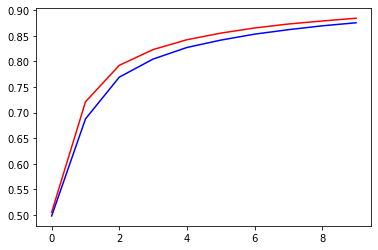

In [51]:
sns.lineplot(x = [i for i in range(10)], y = genre_scores, c= 'r')
sns.lineplot(x = [i for i in range(10)], y = cluster_scores, c = 'b')

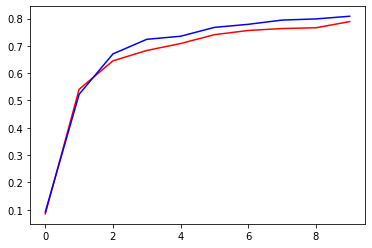

In [258]:
def run_lightfm(var, df, features, epochs = 5):
    
    dataset = Dataset()
    dataset.fit(
        users = set(ratings['profileId']), 
        items = set(df['albumId']),
        item_features=list(set(df[var])))
    
    album_features = dataset.build_item_features(df[features])
    
    model = lightfm.LightFM(
        no_components=50,
        learning_rate=0.05,
        loss='warp',
        random_state=1)

    model.fit(sparse.csr_matrix(ratings_df_interaction).tocoo(),
        item_features=album_features,
        epochs=epochs, num_threads=4, verbose=False)
    
    return calculate_precis_score(model, sparse.csr_matrix(ratings_df_interaction).tocoo(), album_features)

genre_scores = []
cluster_scores = []
for i in range(10):
    genre_scores.append(run_lightfm('genreName', albums_by_genre, 'genreFeatures', i ))
    cluster_scores.append(run_lightfm('albumCluster', albums_by_cluster, 'clusterFeatures', i ))
    
sns.lineplot(x = [i for i in range(10)], y = genre_scores, c= 'r')
sns.lineplot(x = [i for i in range(10)], y = cluster_scores, c = 'b')

In [113]:
albums_by_cluster['clusterFeatures'].values

array([(35406, ['14']), (15195, ['14']), (15394, ['16']), ...,
       (8660, ['16']), (117, ['16']), (15804, ['2'])], dtype=object)

In [129]:
# making a perm dataset
dataset = Dataset()
dataset.fit(
    users = (ratings['profileId']), 
    items = (ratings['albumId']),
    item_features = albums_by_cluster['albumCluster'])

album_features = dataset.build_item_features(albums_by_cluster['clusterFeatures'])

model = lightfm.LightFM(
    no_components=50,
    learning_rate=0.05,
    loss='warp',
    random_state=1)

model.fit(sparse.csr_matrix(ratings_df_interaction).tocoo(),
    item_features=album_features,
    epochs=10, num_threads=4, verbose=False)

ValueError: Feature 14 not in eature mapping. Call fit first.

In [87]:
np.array(list(df['albumId']), dtype='int32')[0:5]

array([35406, 35406, 35406, 35406, 35406], dtype=int32)

In [88]:
album_features

<6802x6822 sparse matrix of type '<class 'numpy.float32'>'
	with 13604 stored elements in Compressed Sparse Row format>

In [93]:
ratings.profileId.shape, ratings.albumId.shape

((40052,), (40052,))

In [106]:
ratings.albumId.unique().shape

(6802,)

In [97]:
ratings.profileId[:5].astype(int), ratings.albumId[:5]

(0     85
 9     60
 18    42
 27    58
 36    25
 Name: profileId, dtype: int64, 0     35406
 9     35406
 18    35406
 27    35406
 36    35406
 Name: albumId, dtype: int64)

In [109]:
album_features.T

<6822x6802 sparse matrix of type '<class 'numpy.float32'>'
	with 13604 stored elements in Compressed Sparse Column format>

In [112]:
model.predict(ratings.profileId.astype(int).values,#np.array(list(ratings['profileId']), dtype='int32')[0:album_features.shape[0]],
              ratings.albumId.values,#np.array(list(df['albumId']), dtype='int32')[0:album_features.shape[1]],
              item_features=album_features.T
             )

Exception: Number of item feature rows does not equal the number of items

In [ ]:
#my guys old method
def recommend_questions(user_ids):
     
    for user in user_ids:

        previous_album_id_num = ratings.loc[ratings['profileId'] == 42]['albumId']
        df_previous_albums = ratings.loc[ratings['albumId'].isin(previous_album_id_num)]

        discard_album_id = df_previous_albums['albumId'].unique().tolist()
        df_use_for_prediction = ratings.loc[~ratings['albumId'].isin(discard_album_id)]
        album_id_for_predict = df_use_for_prediction['albumId'].unique().tolist()
        
        scores = model.predict(([user]*(len(album_id_for_predict))),
                               album_id_for_predict,
                               item_features=album_features)
        
        return scores
        #df_use_for_prediction['scores'] = scores
        #df_use_for_prediction = df_use_for_prediction.sort_values(by='scores', ascending=False)[:8]
        #print('Professional Id (' + str(professional) + "): Recommended Questions: ")
        #display(df_use_for_prediction[['questions_title', 'question_features']])

In [244]:
#recommend_questions([42.0])

Retry!

In [303]:
new_ratings_df = ratings_df.reset_index(drop=True)

In [321]:
new_album_dict = dict(enumerate(new_ratings_df.columns))
new_album_dict = {value:key for key, value in new_album_dict.items()}

In [323]:
new_ratings_df.columns = new_ratings_df.columns.to_series().map(new_album_dict)

In [300]:
#albums_by_cluster = df[['albumId', 'albumArtist', 'albumCluster']].drop_duplicates()
#albums_by_genre = df[['albumId', 'albumArtist', 'genreName']].drop_duplicates()
#ratings = df[['profileId', 'albumId', 'score']].drop_duplicates()

# def create_lfm_features(dataframe, features_name, id_col_name):
#     features = dataframe[features_name].apply(lambda x: str(x))
#     features = features.str.split(',')
#     features = list(zip(dataframe[id_col_name], features))
#     return features

# genre_features = create_lfm_features(albums_by_genre, 'genreName', 'albumId')
# cluster_features = create_lfm_features(albums_by_cluster, 'albumCluster', 'albumId')

# albums_by_cluster['clusterFeatures'] = cluster_features
# albums_by_genre['genreFeatures'] = genre_features

# ratings_df_interaction = ratings_df.applymap(lambda x: 1 if float(x)>0 else 0)

dataset = Dataset()
dataset.fit(
    users = set(ratings['profileId']), 
    items = set(df['albumId']),
    item_features = albums_by_cluster['albumCluster'])

album_features = dataset.build_item_features(albums_by_cluster['clusterFeatures'])

model = lightfm.LightFM(
    no_components=50,
    learning_rate=0.05,
    loss='warp',
    random_state=1)

model.fit(sparse.csr_matrix(ratings_df_interaction).tocoo(),
    item_features=album_features,
    epochs=10, num_threads=4, verbose=False)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70] [   0    1    2 ... 6799 6800 6801]


In [252]:
index = ratings['profileId'].unique()
mapp = dataset.mapping()
dict_user_id = mapp[0]
dict_item_id = mapp[2]
pid_array = np.arange(len(dict_item_id), dtype=np.int32)
d_user_pred = {}

for user in dict_user_id.keys():
    d_user_pred[user] = []

    scores = model.predict(np.arange(len(dict_user_id)), np.arange(len(dict_item_id)),
                           item_features=album_features)
    #top_items = item['item_id'][np.argsort(-scores)]
    
    #for index, user_id in dict_user_id.items(): 

AssertionError: 

In [245]:
#place zeroes in place of everything that you dont want to include
#for user in 
preds = model.predict(user_ids = 42,
                      item_ids = albums_by_cluster['albumId'],
                      item_features=album_features)

In [ ]:
tuning params:
    param = {'no_components': 314,
         'learning_schedule': 'adagrad',
         'loss': 'warp-kos',
         'learning_rate': 0.010372998003563394,
         'item_alpha': 1.0041412735137758e-06, 
         'user_alpha': 4.364266509627352e-09, 
         'max_sampled': 20,
         'num_epochs': 57}

In [293]:
# do we need another matrix for user_features
dataset = Dataset()
dataset.fit(
    users = set(ratings['profileId']), 
    items = set(albums_by_cluster['albumId']),
    item_features=list(set(albums_by_cluster['clusters'])))

In [294]:
album_features = dataset.build_item_features(albums_by_cluster['cluster_features'])

In [255]:
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 71, num_items 6802.


In [238]:
# #may need weights in this...
# temp_intereact_matrix = list(zip(
#     ratings['profileId'], albums_by_cluster['albumId']))

# interactions = dataset.build_interactions(   
#     temp_intereact_matrix)

In [316]:
model = lightfm.LightFM(
    no_components=150,
    learning_rate=0.05,
    loss='warp',
    random_state=1)

model.fit(sparse.csr_matrix(ratings_df_interaction).tocoo(),
    item_features=album_features,
    epochs=2, num_threads=4, verbose=True)

Epoch 0
Epoch 1


In [317]:
calculate_auc_score(model, sparse.csr_matrix(ratings_df_interaction).tocoo(), album_features)

0.8531844

In [190]:
def split_data(data):
    train, test = train_test_split(data, test_size = .2)
    train_data = tc.SFrame(train)
    test_data = tc.SFrame(test)
    return train_data, test_data

In [192]:
train_cluster, test_cluster = split_data(albums_by_cluster)

In [193]:
train_cluster = sparse.csr_matrix(train_cluster.values).tocoo()
test_cluster = sparse.csr_matrix(test_cluster.values).tocoo()

AttributeError: 'SFrame' object has no attribute 'values'

In [196]:
model = lightfm.LightFM(learning_rate=0.05, loss='bpr')
model.fit(train_cluster, epochs=10)

AttributeError: 'SFrame' object has no attribute 'tocoo'

In [157]:
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()
print(train_precision, train_auc)
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

NameError: name 'precision_at_k' is not defined